In [6]:
# Calculate potential temperatuire anomaly distribution
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import gsw

In [7]:
Hs = 10
Qf = 700
file = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/state700/Hs_' + str(format(Hs,'03d')) + '.nc')
t0 = 60
tn = len(file.T)
state = file.isel(Y=range(1,10), T=range(t0,tn))
X = state.X.data 
x_dist = X / 1000
depth = state.Z.data
pres = gsw.p_from_z(depth, 0)
pt = state.Temp.data.mean(axis=(0,2)) # Y-axis average
s = state.S.data.mean(axis=(0,2))

p = np.tile(pres,[50,1]).T
rho = gsw.rho(s, pt, p)


u0 = state.U.data # dims = T, Z, Y, Xp1
u_ymean = (u0[:, :, :, 1:].mean(2) + u0[:, :, :, :-1].mean(2)) / 2
u = u_ymean.mean(0) # dims = Z, X
u[u==0] = np.nan

In [8]:
# Find the uppler and lower layer depth above the sill crest
def Layer(u):
    # Layer interface, zero velocity crossing point
    #l = np.empty(len(X)-2)
    h1 = np.empty(len(X)-2)
    z_th = np.empty(len(X)-2)
    for i in range(1,len(X)-1):
        l = np.where(u[:, i] < 0)[-1][0] - 1
        #z_th[i-1] =  w[l, i] * pt[l, i]
        #h1[i-1] = -depth[l]
        # Calculate layer depth
        if l <= 9:
            h1[i-1] = -depth[l]+0.25
        elif l <= 19:
            h1[i-1] = -depth[l]+0.5
        elif l <= 29:
            h1[i-1] = -depth[l]+0.75
        elif l <= 39:
            h1[i-1] = -depth[l]+2
        elif l <= 49:
            h1[i-1] = -depth[l]+4
    return h1

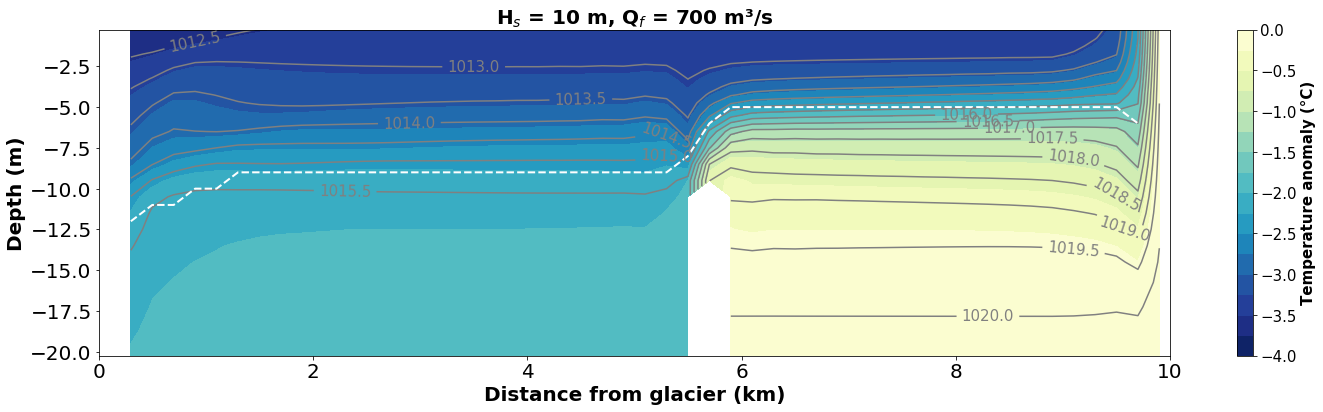

In [9]:
pt0 = file.Temp.data.mean(2)[1,:,:]
mask = (pt0 == 0)
pt[mask] = np.nan
s[mask] = np.nan
rho[mask] = np.nan
h1 = Layer(u)


fig_path = "/Users/weiyangbao/Documents/Model_outputs/Theta/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
    
fig, ax = plt.subplots(figsize=(24,6))  
# Plot potential temperature field
ct = np.linspace(-4,0,17) # Contour range for temperature
plt.contourf(x_dist,depth[:24],pt[:24,:]-9, ct, cmap='YlGnBu_r')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Temperature anomaly (\N{DEGREE SIGN}C)', size=15, weight='bold')

# Plot isopycnals
CS = plt.contour(x_dist,depth[:24],rho[:24,:],17, colors = 'gray')
plt.clabel(CS, fmt='%1.1f', fontsize=15, inline=1)


plt.plot(x_dist[1:-1],-h1, '--w', lw=2)
#ax.axvline(x_dist[28],color='g', lw=2)

plt.title('H$_{s}$ = '  + str(Hs) + ' m, Q$_{f}$ = ' + str(Qf) + ' m\u00B3/s', size=20, weight='bold')
ax.set_xlim([0,10])
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
ax.set_xlabel('Distance from glacier (km)', size=20, weight='bold')
ax.set_ylabel('Depth (m)', size=20, weight='bold')
fig.savefig(fig_path + '/TH_anomaly' + str(Hs) + '.png', dpi = 150, bbox_inches='tight')

In [10]:
a =pt -9
a = a[~np.isnan(a)]
a.max()

0.0